### Spatial Trend Modeling, 2D + 1D = 3D

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of  **3D Trend Modeling** with a practical 2D + 1D approach. We assume that the 2D and 1D trends are calculated from data, we load the former and assume a simple function for the latter. 

**YouTube Lecture**: check out my lecture on [Trend Modeling](https://www.youtube.com/watch?v=BCnivpSKF18&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=41). For convenience here's a summary of trend modeling.

#### Trend Modeling  

* We must identify and model trends
* Trends in model statistics (e.g., mean) are also known as ‘nonstationarities’

We discuss data-driven trend modeling here, but any trend model should include data integration over the entire subsurface asset team

* Geology
* Geophysics
* Petrophysics
* Reservoir Engineering

We often build hybrid models by summing 2 components:

* trend model for the mean
* stochastic residual model 

Any variance in the [assumed] known trend is removed from the unknown residual:

$$
\sigma_X^2 = \sigma_{X_t}^2 + \sigma_{X_r}^2 + 2 \cdot C_{X_t,X_r} 
$$

If $\sigma_X^2$ is the total variance (variability), and $\sigma_{X_t}^2$ is the variability that is a deterministic trend model, treated as known, and $\sigma_{X_r}^2$  is the component of the variability that is treated as an unknown, stochastic residual.  

Result: the more variability explained by the trend the less variability that remains as uncertain.

#### Deterministic Trend Model

Model that assumes perfect knowledge, without uncertainty

* Based on knowledge of the phenomenon or trend fitting to data 

* Most subsurface models have a deterministic component (trend) to capture expert knowledge and to provide a stationary residual for geostatistical modeling. 

#### Stochastic Residual

The unknown residual is modeled as a stochastic, statistical model

* Model that integrates uncertainty through the concept of random variables and functions

* Based primarily on data-driven statistics and various forms of integration of domain and local knowledge 

* Most subsurface models have a stochastic component (residual) to quantify the uncertain component of the model (as opposed to the certain component from the trend model)

Note, more about stochastic, statistical models later this lecture and over the next few lectures.

#### Common Hybrid Trend and Stochastic Residual Modeling Workflow

1. Start with spatial data, $𝑍(\bf{𝐮}_{\alpha}), 𝛼=1,\ldots,𝑛$ data

2. Fit a deterministic trend model to the data to model nonstationarity in the mean, at data $𝑍_t(\bf{𝐮}_{\alpha})$ and away from data, $𝑍_t(\bf{𝐮}_{\beta}), \beta=1,\ldots,𝑛_𝑐$ model cells

3. Calculate the residual at data locations, $𝑍_r(\bf{𝐮}_{\alpha}) = 𝑍(\bf{𝐮}_{\alpha}) - 𝑍_t(\bf{𝐮}_{\alpha})$

4. Calculate and model a statistical residual away from the data, $𝑍_r(\bf{𝐮}_{\beta})$

5. Add the trend and residual models to calculate the trend + residual model, $𝑍(\bf{𝐮}_{\beta}) = 𝑍_t(\bf{𝐮}_{\beta}) + 𝑍_r(\bf{𝐮}_{\beta})$

#### Calculating Trend Models

How to calculate a trend model with sparse data

* Break the problem up into a 1D and 2D trend inference problem and then combine to calculate a reasonable 3D trend 

* Calculate the 2D areal trend by interpolating over vertically averaged wells. 

* Calculate the 1D vertical trend by averaging layers

* Combine the 1D vertical and the 2D areal trends:

$$
\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y},\bf{𝐮}_{z}) = \overline{Z}(\bf{𝐮}_{z}) \cdot \frac{\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y})}{\overline{Z}}
$$

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
cmap = plt.cm.inferno

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a function to help visualize our 3D model with the PyVista python package.

In [2]:
def fence_diagram(array3d,xsections,ysections,zscalefactor):
    import pyvista as pv   
    pv.set_plot_theme("document")
    
    lighting = True; off_screen = True; notebook = False
    
    plotter = pv.Plotter(off_screen=off_screen,notebook=notebook,window_size=[5000, 5000])
    
    light = pv.Light(position=(-50, 0, 150), show_actor=False, positional=True,
                     cone_angle=180, exponent=20, intensity=1.)
    plotter.add_light(light)
    
    mesh = pv.wrap(array3d)
    
    for xsection in xsections:
        slices = mesh.slice(normal=[1, 0, 0],origin=(xsection,0,0)) 
        plotter.add_mesh(mesh=slices,style='surface',cmap=plt.cm.inferno,show_scalar_bar=False,lighting=lighting,diffuse=1.0,opacity=opacity,
                    show_edges=False,clim=[0,2000])
    
    for ysection in ysections:
        slices = mesh.slice(normal=[0, 1, 0],origin=(0,ysection,0)) 
        plotter.add_mesh(mesh=slices,style='surface',cmap=plt.cm.inferno,show_scalar_bar=False,lighting=lighting,diffuse=1.0,opacity=opacity,
                    show_edges=False,clim=[0,2000])
    
    plotter.camera_position = [-1.0,-1.0,1.0]
    
    plotter.set_scale(zscale=zscalefactor)
    plotter.show(screenshot='airplane.png')
    
    plt.imshow(plotter.image)

#### Load the 2D Areal Trend Model, $\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y})$

We load the 2D trend model from my [GeoDataSets](https://github.com/GeostatsGuy/GeoDataSets) repository. 

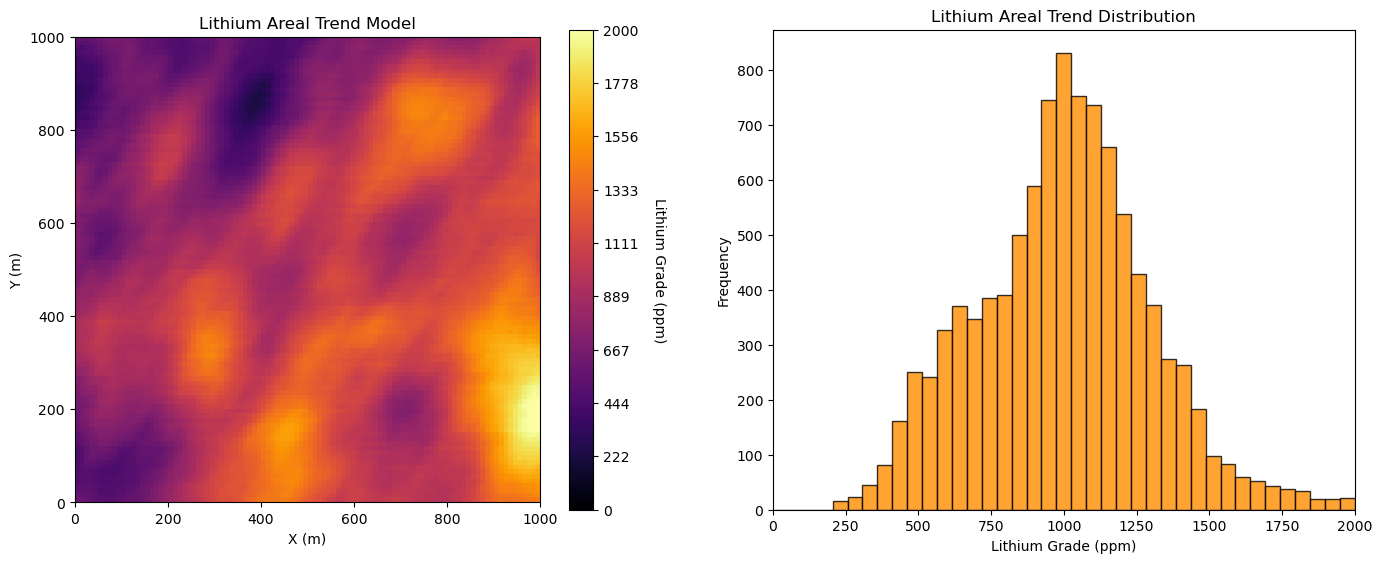

In [3]:
lithium_areal_trend = np.loadtxt(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/Lithium_Trend_Map.csv', delimiter=",")

global_mean = 1000.0
xmin=0; ymin=0; xmax=1000; ymax=1000;
vmin=0;vmax=2000

nx = 100; ny = 100; nz = 30
xsiz=10.0; ysiz=10.0; zsiz=1.0
xmn=xsiz/2; ymn=ysiz/2; zmn=zsiz/2

plt.subplot(121)
im = plt.imshow(lithium_areal_trend,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
plt.title('Lithium Areal Trend Model')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Lithium Grade (ppm)', rotation=270, labelpad=20)

plt.subplot(122)
plt.hist(lithium_areal_trend.flatten(),bins=np.linspace(0,2000,40),color='darkorange',alpha=0.8,edgecolor='black')
plt.xlabel('Lithium Grade (ppm)'); plt.ylabel('Frequency'); plt.title('Lithium Areal Trend Distribution')
plt.xlim([0,2000])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Assume a 1D Vertical Trend, $\overline{Z}(\bf{𝐮}_{z})$

We assume a simple model with additive linear and periodic components.

Text(0.5, 1.0, 'Lithium Vertical Trend Model')

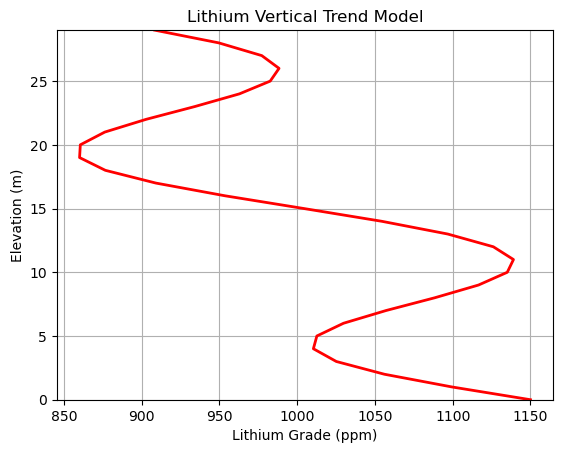

In [4]:
vgradient = 10.0; amp = 100.0; lambd = 10

z = np.arange(0,30,1)
lithium_vertical_trend = (z-15)*-1*vgradient + amp*np.sin(3.1*lambd*z) + global_mean

plt.plot(lithium_vertical_trend,z,color='red',lw=2)
plt.ylim([0,29]); plt.grid()
plt.xlabel('Lithium Grade (ppm)'); plt.ylabel('Elevation (m)'); plt.title('Lithium Vertical Trend Model')

#### Calculate the 3D Trend, $\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y},\bf{𝐮}_{z})$ 

Combine the 2D areal trend, 1D vertical trend and global mean to calculate the 3D trend model. 

$$
\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y},\bf{𝐮}_{z}) = \overline{Z}(\bf{𝐮}_{z}) \cdot \frac{\overline{Z}(\bf{𝐮}_{x},\bf{𝐮}_{y})}{\overline{Z}}
$$

In [5]:
lithium_3D_trend = np.zeros([ny,nx,nz])

for iy in range(0,ny):
    for ix in range(0,nx):
        for iz in range(0,nz):
            lithium_3D_trend[iy,ix,iz] = lithium_vertical_trend[iz]*lithium_areal_trend[iy,ix]/global_mean

#### Visualize the 3D Trend Model

Now let's use PyVista to build a fence plot of the full 3D trend model.

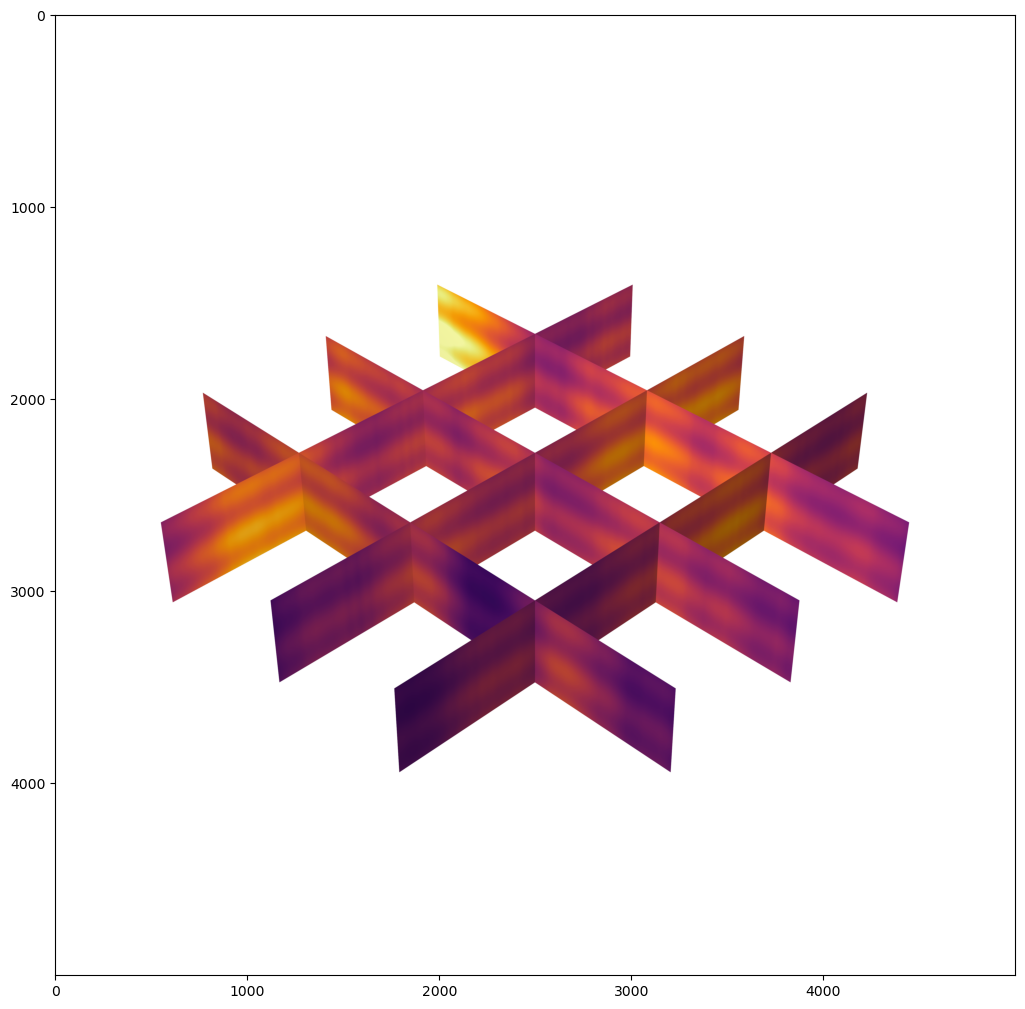

In [6]:
xsections = [25,50,75]; ysections = [25,50,75]
zscalefactor = 0.5; opacity = 1.0    

plt.subplot(111)
fence_diagram(lithium_3D_trend,xsections,ysections,zscalefactor);

plt.subplots_adjust(left=0.0, bottom=0.0, right=6.0, top=2.0, wspace=0.6, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of trend modeling to support 3D model construction. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
  